This Jupyter notebook details theoretically the architecture and the mechanism of the Graph Attention Network (GAT). Then, we implement the GAT model for node classification task. <br> 
The notebook was implemented by <i>Nada Chaari</i>, PhD student at Istanbul Technical University (ITU). <br>

# Table of Contents:
    1)Why GAT
    2)GAT layer architecture
    3)Application of GCN using Karate dataset
        3-1) Loading Required Libraries
        3-2) Import Dataset
        3-3) Create the GAT layer
        3-4) Create the GAT model using GAT layers
        3-5) Training the model using Karate dataset
        3-6) Evaluate the model using classification accuracy

source used to build this Jupiter Notebook:: 
* https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/Tutorial3.ipynb
* https://www.youtube.com/watch?v=CwsPoa7z2c8
* https://docs.dgl.ai/en/0.6.x/tutorials/models/1_gnn/9_gat.html

# Why GAT ?

From Graph Convolutional Network (GCN), we learnt that combining local graph structure and node-level features yields good performance on node classification task. However, the way GCN aggregates messages is structure-dependent, which may hurt its generalizability.

The fundamental novelty that GAT brings to the table is how the information from the one-hop neighborhood is aggregated. For GCN, a graph convolution operation produces the normalized sum of neighbors' node features as follows:
$$h_i^{(l+1)}=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\frac{1}{c_{ij}} W^{(l)}h^{(l)}_j}\right)$$

where $\mathcal{N}(i)$ is the set of its one-hop neighbors (to include $v_{i}$ in the set, we simply added a self-loop to each node), $c_{ij}=\sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}$ is a normalization constant based on graph structure, $\sigma$ is an activation function (GCN uses ReLU), and $W^{l}$ is a shared weight matrix for node-wise feature transformation.

GAT introduces the attention mechanism as a substitute for the statically normalized convolution operation. The figure below clearly illustrates the key difference.

<img src='https://raw.githubusercontent.com/dsgiitr/graph_nets/e3ede10d9de0b3849d0a5180a92233c0b42375a9/GAT/img/GCN_vs_GAT.jpg' width='800'  align="center">


### How much features we need of nodes 2 are important to node 1 ?

Graph attention layer: 
* The input to the layer is a set of node features, $\mathbf{h} = \{\vec{h}_1,\vec{h}_2,...,\vec{h}_N\}, \vec{h}_i ∈ \mathbb{R}^{F}$ , where $N$ is the number of nodes, and $F$ is the number of features in each node. 
* The layer produces a new set of node features (of potentially different cardinality $F'$ ), $\mathbf{h} = \{\vec{h'}_1,\vec{h'}_2,...,\vec{h'}_N\}, \vec{h'}_i ∈ \mathbb{R}^{F'}$, as its output. 

# GAT layer architecture
 1) Parameterized linear transformation to every node: Equation (1) is a linear transformation of the lower layer embedding (feature vectors of the nodes) $h^{(l)}_{i}$ and $W^(l)$ is its learnable weight matrix.

 2) Attention mechanism: a is a single-layer feedforward neural network,parametrized by a weight vector $ \overrightarrow{a} \in \mathbb{R}^{2F'}$, and applying the LeakyReLU nonlinearity (with negative
input slope α = 0.2). Equation (2) computes a pair-wise unnormalized attention score between two neighbors. $e^{i,j}$: specifies the importance of node's $j$ features to node $i$ Here, it first concatenates the z embeddings of the two nodes, where || denotes concatenation, then takes a dot product of it and a learnable weight vector $a⃗ ^{(l)}$, and applies a LeakyReLU in the end.

 3) Normalization: Equation (3) applies a softmax to normalize the attention scores on each node’s incoming edges. and to make coefficients easily comparable across different nodes.

 4) Aggregation: Equation (4) is similar to GCN. The embeddings from neighbors are aggregated together, scaled by the attention scores.

<img src='https://miro.medium.com/max/1400/1*QZ_chTmUY6Yj5tb0kWCatg.png' width='500'  align="center">

$\mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},$ 
        where the attention coefficients :$\alpha_{i,j}$ are computed as

$\alpha_{i,j} = \frac{\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]\right)\right)}{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]\right)\right)}$.

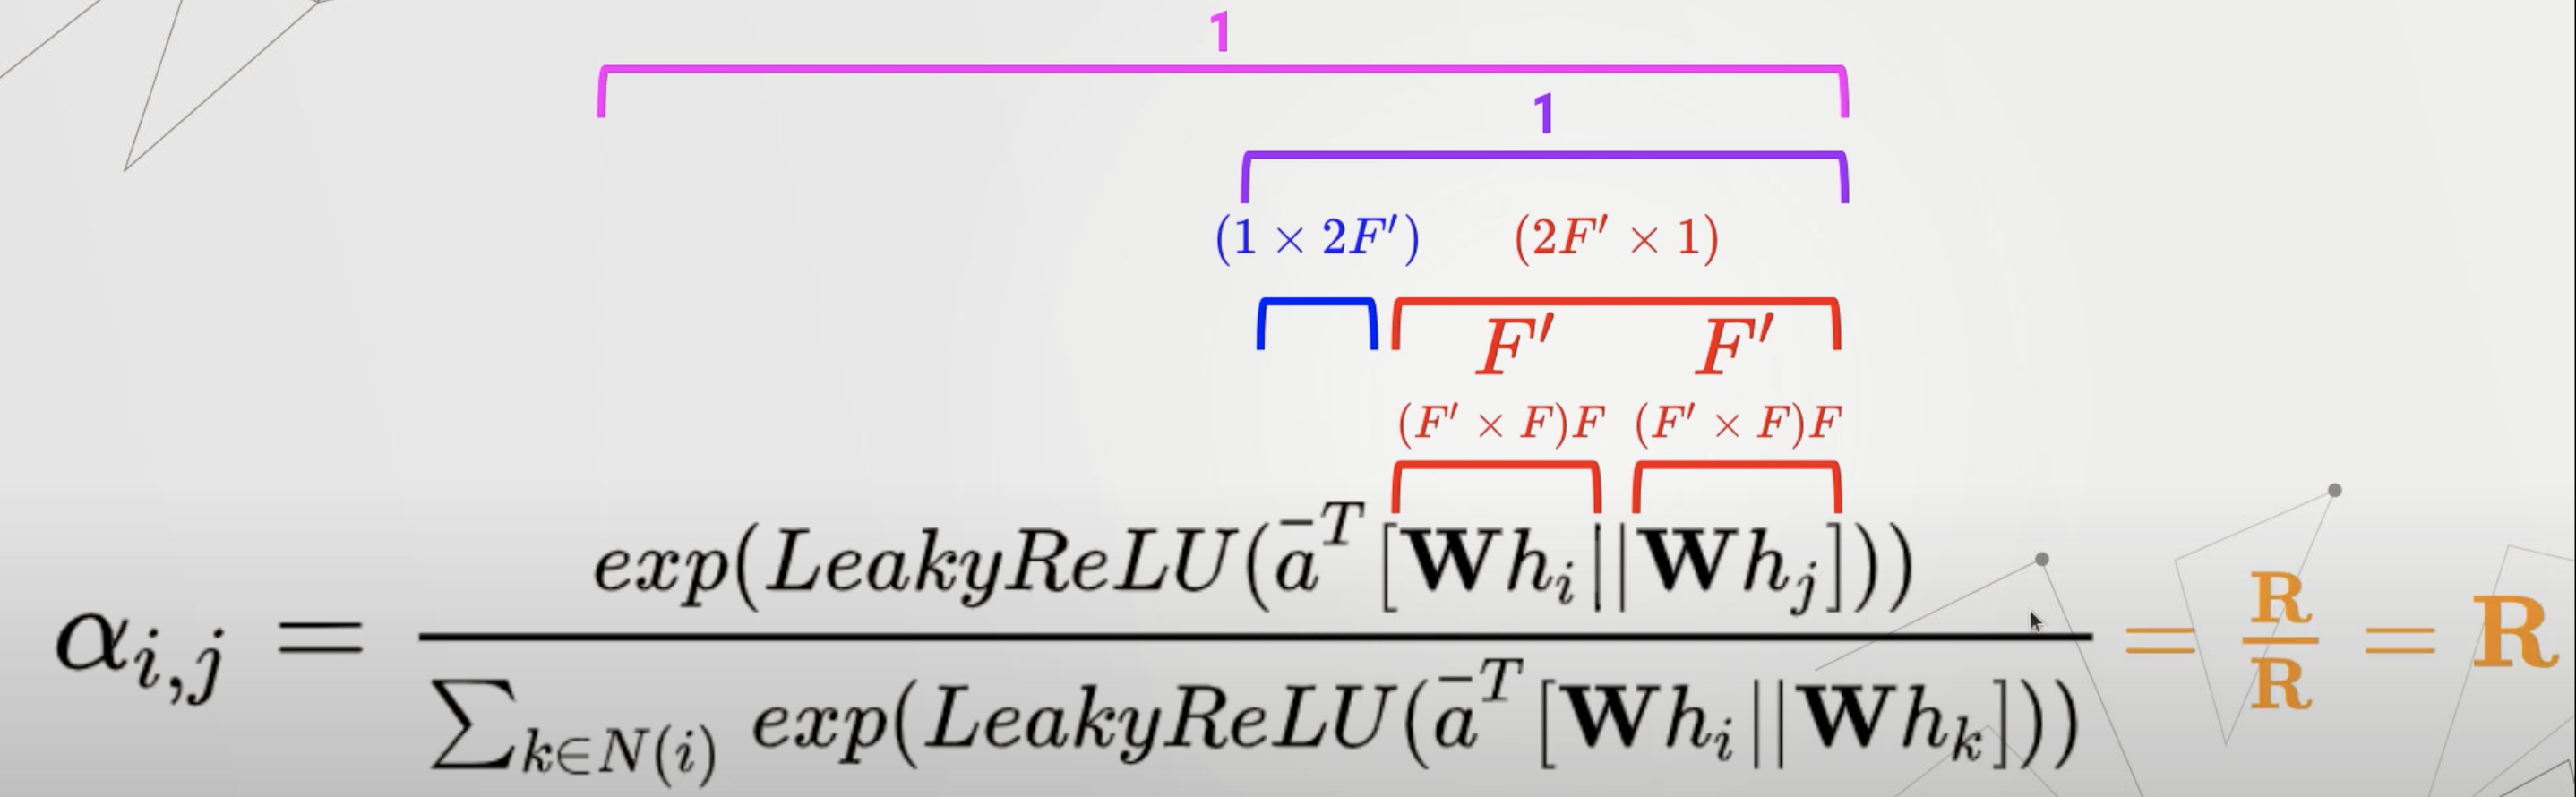

In [26]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/normalization.png", width = 800, height = 400)

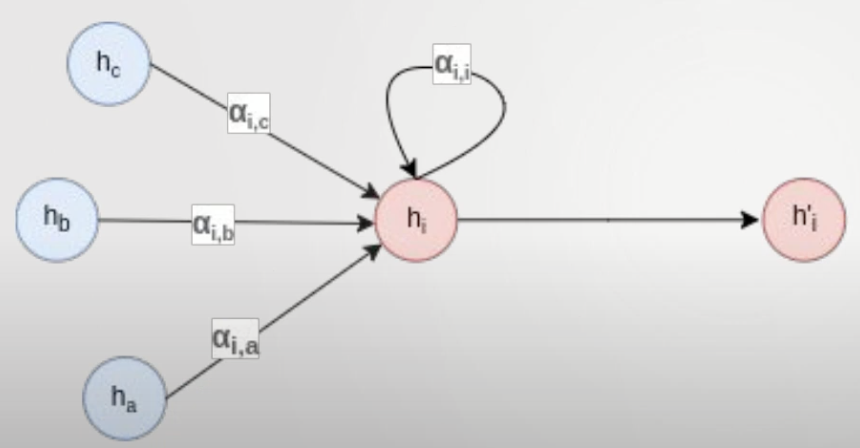

In [27]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/one_head_attention.png", width = 400, height = 200)

 By stacking layers in which nodes are able to attend over their neighborhoods’ features, the method enables (implicitly) specifying different weights to different nodes in a neighborhood,

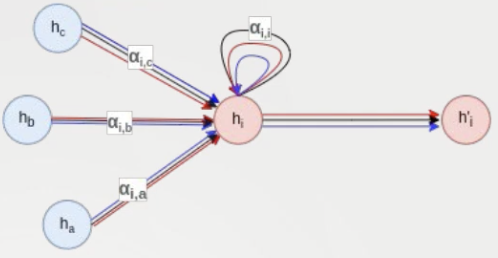

In [28]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/multi_heads_attention.png", width = 400, height = 200)

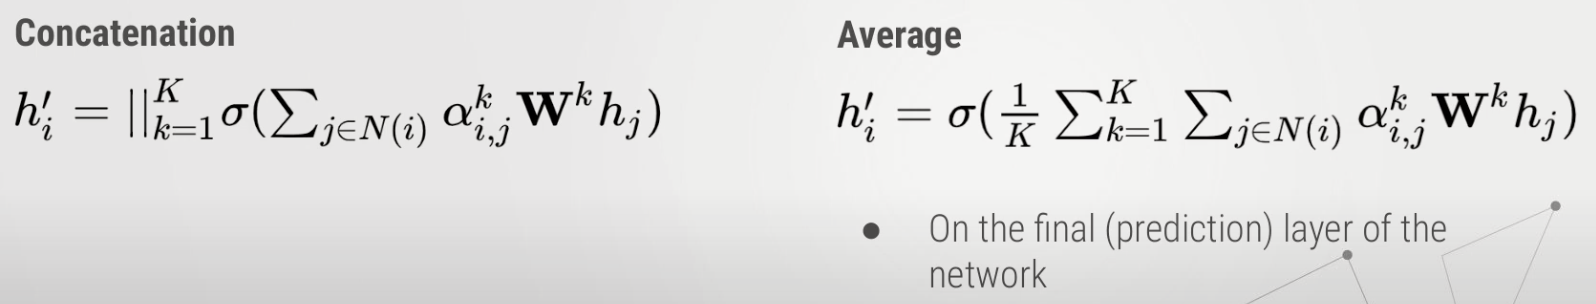

In [29]:
from IPython.display import Image
Image(filename = "/home/irekik/Downloads/conct_aver.png", width = 800, height = 400)

# Application of GAT using Karate dataset

###  1) Loading Required Libraries

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2020) # seed for reproducible numbers

### 2)  Import Dataset

In [6]:
from torch_geometric.datasets import KarateClub # for loading the dataset KarateClub
dataset = KarateClub()
data = dataset[0]

### 3) Create the GAT layer

In [7]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features))) # initialize parameters of W 
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

### 4)  Create the GAT model using GAT layers

In [8]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        #self.conv1 = GATLayer(dataset.num_features, self.hid, dropout, alpha, concat=True)
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6, concat=True) 
        # parameters: (F = 34 (current dimension), F' = 8(embedding dimension for each head), K=8(number of heads)
        # 1st layer: input [34,34] --> output: [34,64]  (64 = 8 * 8) 
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)
        # parameters: (F = 64 (current dimension), F' = 4(embedding dimension for each head), K=1(number of heads)
        # 2nd layer: input [34,64] --> output: [34,4]  (64 = 8 * 8) 
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
        # One can skip them if the dataset is sufficiently large.
        x = self.conv1(x, edge_index)# h [34,34] --> h': [34,64]
        x = self.conv2(x, edge_index) # h [34,64] --> h': [34,4]
        return F.log_softmax(x, dim=1) # h': [34,4] 
     # log softmax : get probability for each class and sum over 4 classes=1

### 5)  Training the model using Karate dataset

In [18]:
model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
losses= []
for epoch in range(1000):
    model.train() # turning the training mode on
    out = model(data) # forward pass 
    optimizer.zero_grad() # reinitiate the grqdients for the new epoch
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], reduction='sum') # calculate the loss
    loss.backward() # calculate the gradients
    optimizer.step() # update the weights
    
    # https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
    
    if epoch % 200 == 0:
        print(loss)
        losses.append(loss.item())
    

tensor(5.1653, grad_fn=<NllLossBackward>)
tensor(1.6109, grad_fn=<NllLossBackward>)
tensor(0.0754, grad_fn=<NllLossBackward>)
tensor(0.0564, grad_fn=<NllLossBackward>)
tensor(0.0065, grad_fn=<NllLossBackward>)


<IPython.core.display.Javascript object>


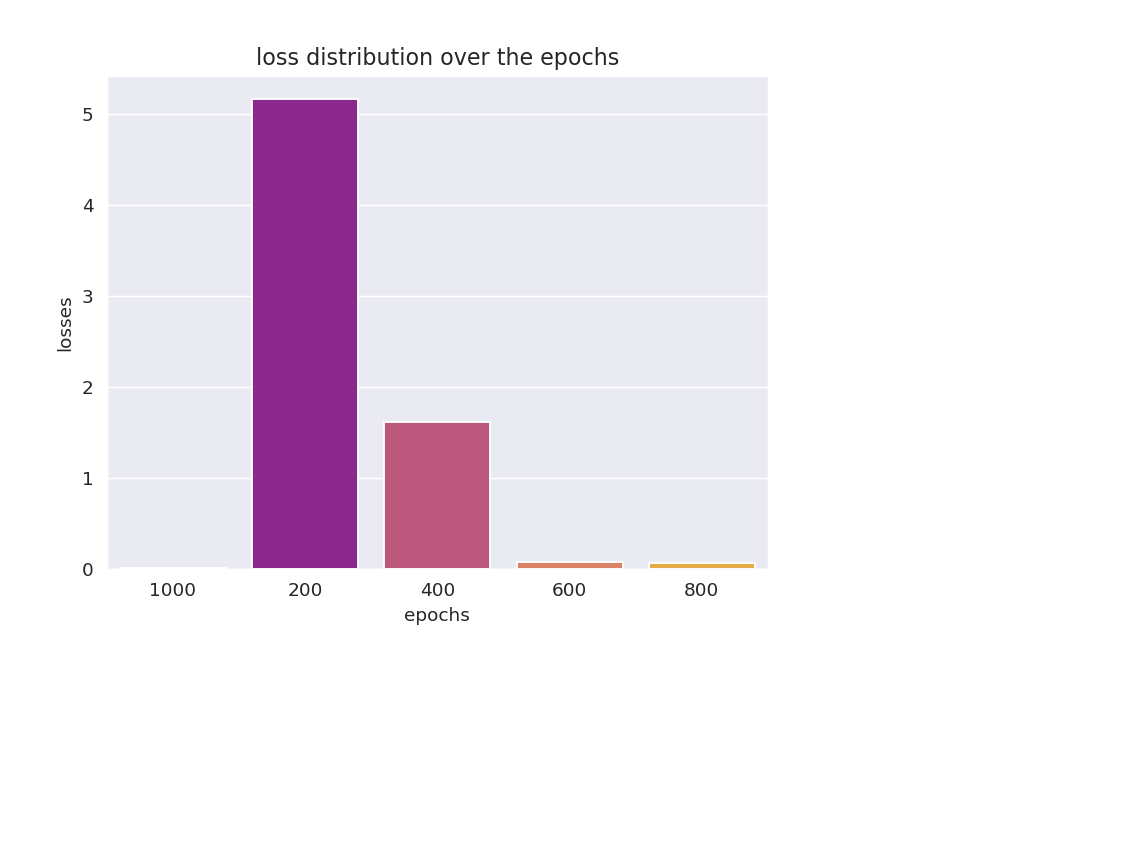

Text(0.5, 1.0, 'loss distribution over the epochs')

In [25]:
import pandas as pd  # Visualizing Statistical Data 
import seaborn as sns # Visualizing Statistical Data 
df = pd.DataFrame({'losses': losses, 'epochs': [ '200', '400', '600', '800', '1000']})
sns.set_style('darkgrid')
# plot the accuracy classification for each class
ax = sns.barplot(x ='epochs', y ='losses', data = df, palette ='plasma')
ax.set_title('loss distribution over the epochs')

In [11]:
print(model.conv1) # 1st layer
print(model.conv2) # 2nd layer

GATConv(34, 8, heads=8)
GATConv(64, 4, heads=1)


### 6) Evaluate the model using classification accuracy

In [12]:
model.eval()
_, pred = model(data).max(dim=1)
test_labels = data.y[data.train_mask==False] 
test_preds = pred[data.train_mask==False]

In [13]:
# calculate the classification accuracy of GCN model 
correct = 0
for i in range(len(test_preds)):
    if test_preds[i] == test_labels[i]:
        correct+=1
acc = correct/len(test_labels)
print(acc)

0.8333333333333334


<IPython.core.display.Javascript object>


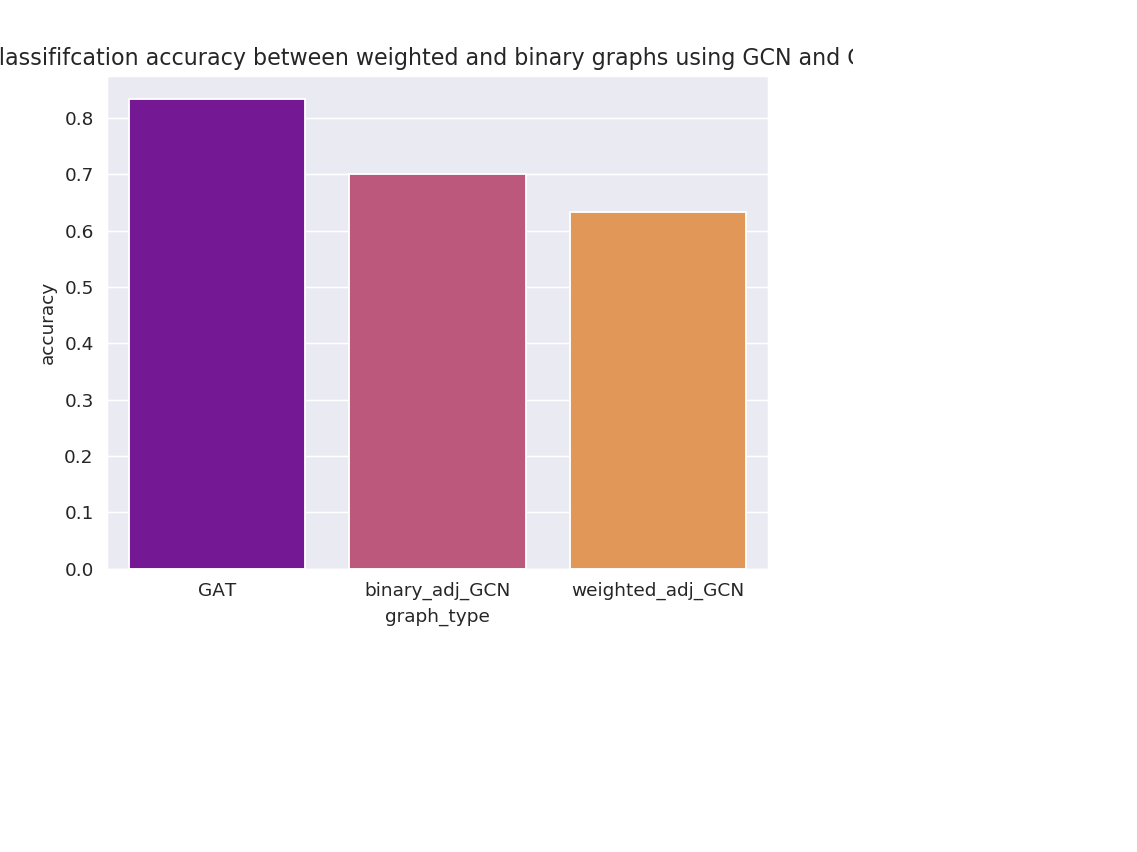

Text(0.5, 1.0, 'comparison of classififcation accuracy between weighted and binary graphs using GCN and GAT architectures ')

In [23]:
df = pd.DataFrame({'accuracy': [acc, 0.7, 0.6333], 'graph_type': ['GAT', 'binary_adj_GCN', 'weighted_adj_GCN' ]})
sns.set_style('darkgrid')
# plot the accuracy classification for each type of graphs
ax = sns.barplot(x ='graph_type', y ='accuracy', data = df, palette ='plasma')
ax.set_title('comparison of classififcation accuracy between weighted and binary graphs using GCN and GAT architectures ')